In [1]:
import numpy as np



import os
from collections import defaultdict
from elastica.wrappers import (
    BaseSystemCollection,
    Connections,
    Constraints,
    Forcing,
    CallBacks,
)
from elastica.rod.cosserat_rod import CosseratRod
from elastica.boundary_conditions import OneEndFixedRod
from elastica.joint import FreeJoint, HingeJoint, FixedJoint
from elastica.callback_functions import CallBackBaseClass
from elastica.timestepper.symplectic_steppers import PositionVerlet, PEFRL
from elastica.timestepper import integrate


In [3]:
import numpy as np
from elastica.external_forces import NoForces

# Force class. This force class is used only for joint test cases
class EndpointForcesSinusoidal(NoForces):
    """ Applies sinusoidal forces on endpoints
    """

    def __init__(
        self,
        start_force_mag,
        end_force_mag,
        ramp_up_time=0.0,
        tangent_direction=np.array([0, 0, 1]),
        normal_direction=np.array([0, 1, 0]),
    ):
        super(EndpointForcesSinusoidal, self).__init__()
        # Start force
        self.start_force_mag = start_force_mag
        self.end_force_mag = end_force_mag

        # Applied force directions
        self.normal_direction = normal_direction
        # self.roll_direction = np.cross(tangent_direction, normal_direction)
        self.roll_direction = np.cross(normal_direction, tangent_direction)

        assert ramp_up_time >= 0.0
        self.ramp_up_time = ramp_up_time

    def apply_forces(self, system, time=0.0):

        if time < self.ramp_up_time:
            # When time smaller than ramp up time apply the force in normal direction
            # First pull the rod upward or downward direction some time.
            start_force = -2.0 * self.start_force_mag * self.normal_direction
            end_force = -2.0 * self.end_force_mag * self.normal_direction

            system.external_forces[..., 0] += start_force
            system.external_forces[..., -1] += end_force

        else:
            # When time is greater than ramp up time, forces are applied in normal
            # and roll direction or forces are in a plane perpendicular to the
            # direction.

            # First force applied to start of the rod
            roll_forces_start = (
                self.start_force_mag
                * np.cos(0.5 * np.pi * (time - self.ramp_up_time))
                * self.roll_direction
            )
            normal_forces_start = (
                self.start_force_mag
                * np.sin(0.5 * np.pi * (time - self.ramp_up_time))
                * self.normal_direction
            )
            start_force = roll_forces_start + normal_forces_start
            # Now force applied to end of the rod
            roll_forces_end = (
                self.end_force_mag
                * np.cos(0.5 * np.pi * (time - self.ramp_up_time))
                * self.roll_direction
            )
            normal_forces_end = (
                self.end_force_mag
                * np.sin(0.5 * np.pi * (time - self.ramp_up_time))
                * self.normal_direction
            )
            end_force = roll_forces_end + normal_forces_end
            # Update external forces
            system.external_forces[..., 0] += start_force
            system.external_forces[..., -1] += end_force


In [8]:

# from examples.JointCases.external_force_class_for_joint_test import (
#     EndpointForcesSinusoidal,
# )
# from examples.JointCases.joint_cases_postprocessing import (
#     plot_position,
#     plot_video,
#     plot_video_xy,
#     plot_video_xz,
# )


class FixedJointSimulator(
    BaseSystemCollection, Constraints, Connections, Forcing, CallBacks
):
    pass


fixed_joint_sim = FixedJointSimulator()

# setting up test params
n_elem = 10
direction = np.array([0.0, 0.0, 1.0])
normal = np.array([0.0, 1.0, 0.0])
roll_direction = np.cross(direction, normal)
base_length = 0.2
base_radius = 0.007
base_area = np.pi * base_radius ** 2
density = 1750
nu = 1e-1
E = 3e7
poisson_ratio = 0.5

start_rod_1 = np.zeros((3,))
start_rod_2 = start_rod_1 + direction * base_length

# Create rod 1
rod1 = CosseratRod.straight_rod(
    n_elem,
    start_rod_1,
    direction,
    normal,
    base_length,
    base_radius,
    density,
    nu,
    E,
    poisson_ratio,
)
fixed_joint_sim.append(rod1)
# Create rod 2
rod2 = CosseratRod.straight_rod(
    n_elem,
    start_rod_2,
    direction,
    normal,
    base_length,
    base_radius,
    density,
    nu,
    E,
    poisson_ratio,
)
fixed_joint_sim.append(rod2)

# Apply boundary conditions to rod1.
fixed_joint_sim.constrain(rod1).using(
    OneEndFixedRod, constrained_position_idx=(0,), constrained_director_idx=(0,)
)

# Connect rod 1 and rod 2
fixed_joint_sim.connect(
    first_rod=rod1, second_rod=rod2, first_connect_idx=-1, second_connect_idx=0
).using(FixedJoint, k=1e5, nu=0, kt=5e3)

# Add forces to rod2
fixed_joint_sim.add_forcing_to(rod2).using(
    EndpointForcesSinusoidal,
    start_force_mag=0,
    end_force_mag=5e-2,
    ramp_up_time=0.2,
    tangent_direction=normal,
    normal_direction=direction,
)

# Callback functions
# Add call backs
class TestJoints(CallBackBaseClass):
    """
    Call back function for testing joints
    """

    def __init__(self, step_skip, callback_params):
        CallBackBaseClass.__init__(self)
        self.every = step_skip
        self.callback_params = callback_params

    def make_callback(self, system, time, current_step):
        if current_step % self.every == 0:
            self.callback_params["time"].append(time)
            self.callback_params["step"].append(current_step)
            self.callback_params["position"].append(system.position_collection.copy())
            self.callback_params["velocity"].append(system.velocity_collection.copy())
            return


pp_list_rod1 = defaultdict(list)
pp_list_rod2 = defaultdict(list)

# FIXME change callback_of to collect_diagnostics
fixed_joint_sim.collect_diagnostics(rod1).using(
    TestJoints, step_skip=1000, callback_params=pp_list_rod1
)
fixed_joint_sim.collect_diagnostics(rod2).using(
    TestJoints, step_skip=1000, callback_params=pp_list_rod2
)


fixed_joint_sim.finalize()
timestepper = PositionVerlet()
# timestepper = PEFRL()

final_time = 2
dl = base_length / n_elem
dt = 1e-5
total_steps = int(final_time / dt)
print("Total steps", total_steps)
integrate(timestepper, fixed_joint_sim, final_time, total_steps)

PLOT_FIGURE = True
SAVE_FIGURE = False
PLOT_VIDEO = True


  0%|          | 102/199999 [00:00<03:16, 1018.49it/s]

Total steps 199999


100%|██████████| 199999/199999 [03:14<00:00, 1025.69it/s]

Final time of simulation is :  1.999999999984833


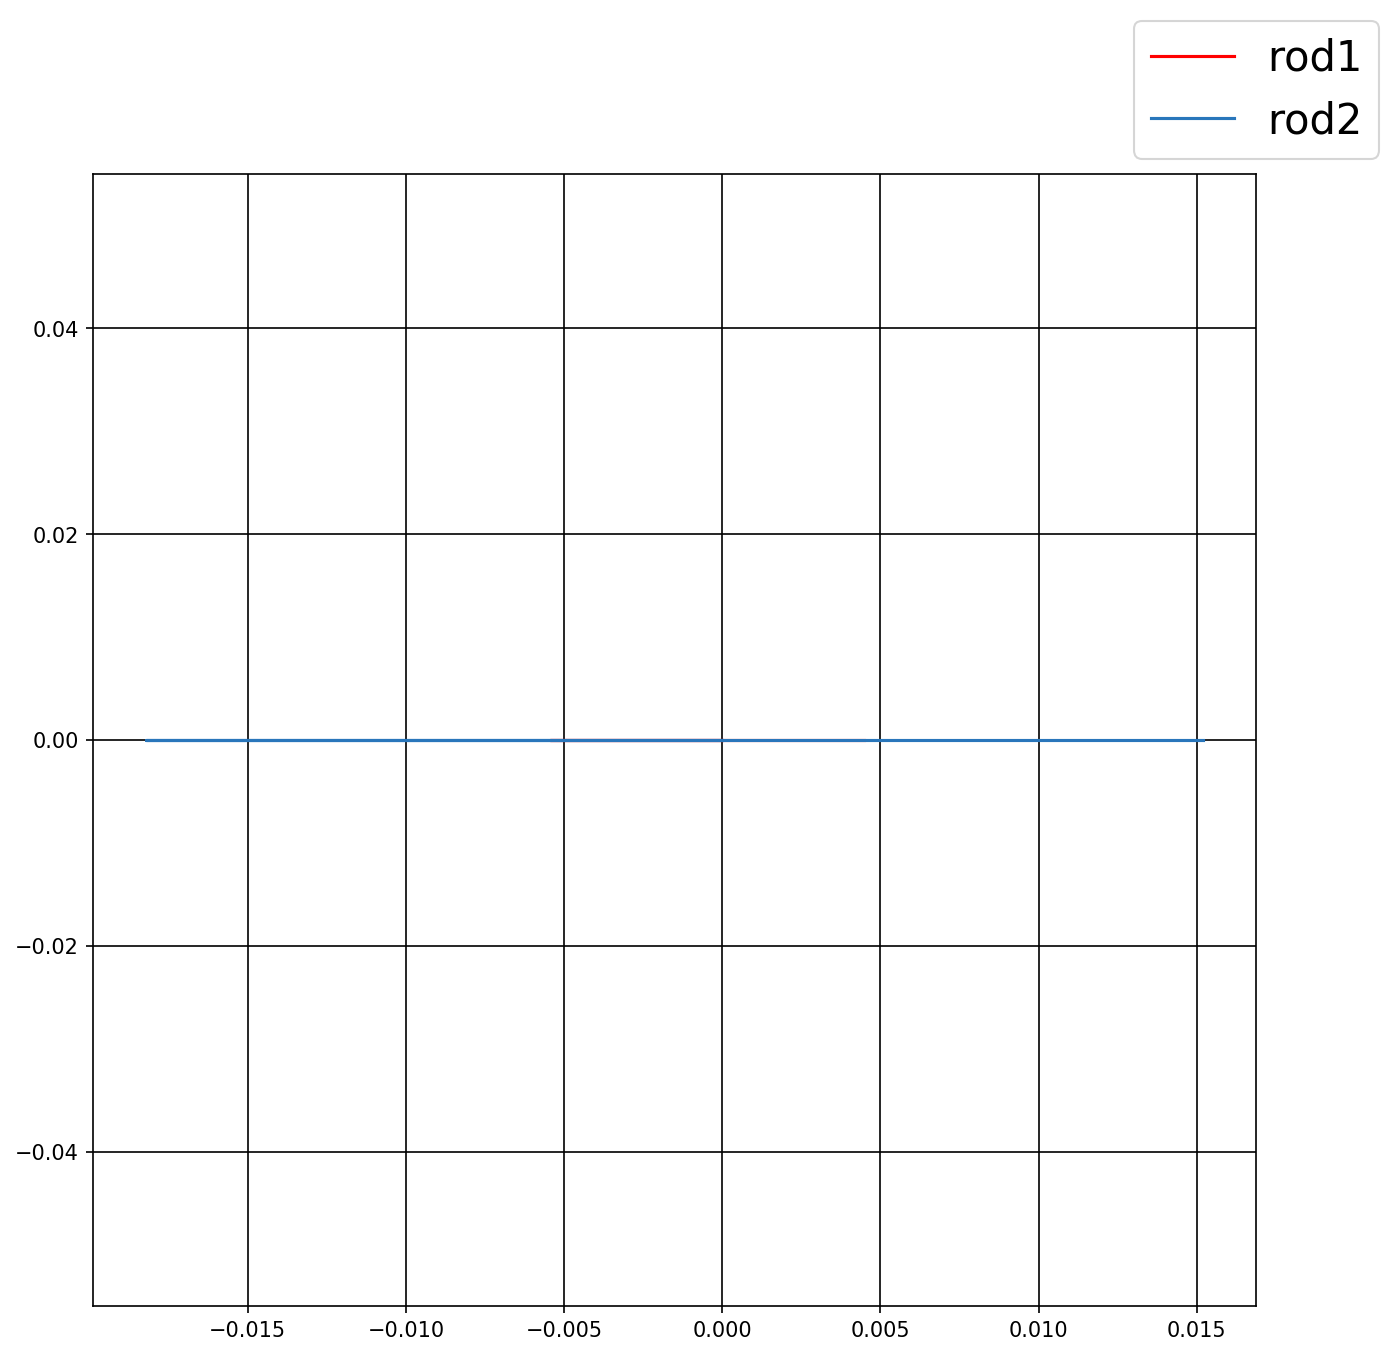

plot video
plot video
plot video


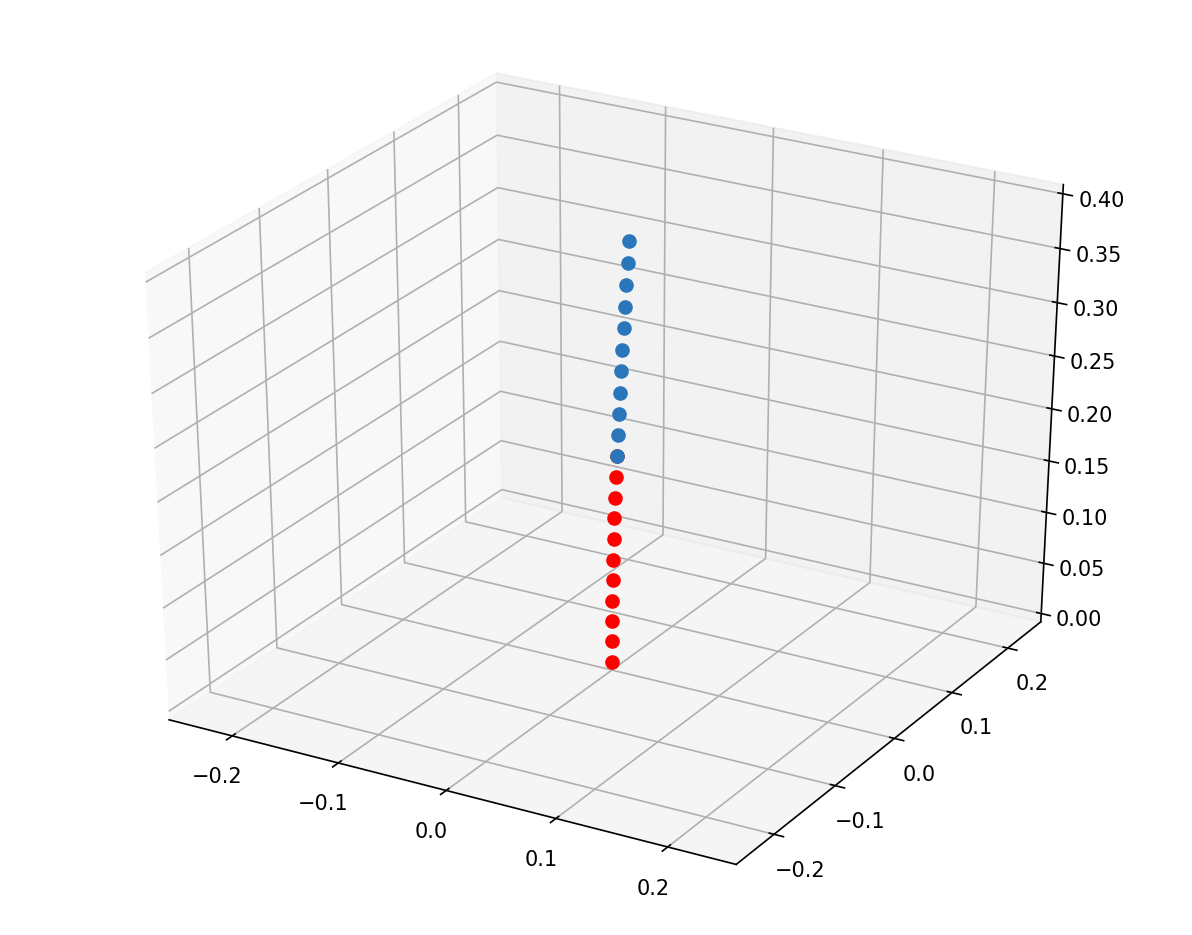

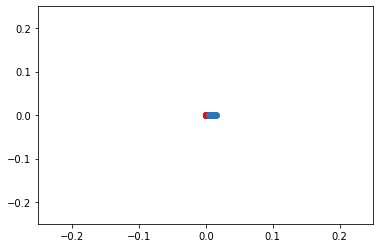

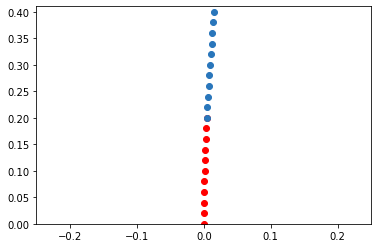

In [9]:

# plotting results
if PLOT_FIGURE:
    filename = "fixed_joint_test.png"
    plot_position(pp_list_rod1, pp_list_rod2, filename, SAVE_FIGURE)

if PLOT_VIDEO:
    filename = "fixed_joint_test.mp4"
    plot_video(pp_list_rod1, pp_list_rod2, video_name=filename, margin=0.2, fps=100)
    plot_video_xy(
        pp_list_rod1, pp_list_rod2, video_name=filename + "_xy.mp4", margin=0.2, fps=100
    )
    plot_video_xz(
        pp_list_rod1, pp_list_rod2, video_name=filename + "_xz.mp4", margin=0.2, fps=100
    )

In [5]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import to_rgb
from mpl_toolkits import mplot3d


def plot_position(plot_params_rod1,
    plot_params_rod2,
    filename="spherical_joint_test.png",
    SAVE_FIGURE=False,
):

    position_of_rod1 = np.array(plot_params_rod1["position"])
    position_of_rod2 = np.array(plot_params_rod2["position"])

    fig = plt.figure(figsize=(10, 10), frameon=True, dpi=150)
    ax = fig.add_subplot(111)

    ax.grid(b=True, which="minor", color="k", linestyle="--")
    ax.grid(b=True, which="major", color="k", linestyle="-")
    ax.plot(position_of_rod1[:, 0, -1], position_of_rod1[:, 1, -1], "r-", label="rod1")
    ax.plot(
        position_of_rod2[:, 0, -1],
        position_of_rod2[:, 1, -1],
        c=to_rgb("xkcd:bluish"),
        label="rod2",
    )

    fig.legend(prop={"size": 20})

    plt.show()

    if SAVE_FIGURE:
        fig.savefig(filename)


def plot_video(
    plot_params_rod1,
    plot_params_rod2,
    video_name="video.mp4",
    margin=0.2,
    fps=15,
):  # (time step, x/y/z, node)
    import matplotlib.animation as manimation

    time = plot_params_rod1["time"]
    position_of_rod1 = np.array(plot_params_rod1["position"])
    position_of_rod2 = np.array(plot_params_rod2["position"])

    print("plot video")
    FFMpegWriter = manimation.writers["ffmpeg"]
    metadata = dict(title="Movie Test", artist="Matplotlib", comment="Movie support!")
    writer = FFMpegWriter(fps=fps, metadata=metadata)
    fig = plt.figure(figsize=(10, 8), frameon=True, dpi=150)
    with writer.saving(fig, video_name, 100):
        for time in range(1, len(time)):
            fig.clf()
            ax = plt.axes(projection="3d")  # fig.add_subplot(111)
            ax.grid(b=True, which="minor", color="k", linestyle="--")
            ax.grid(b=True, which="major", color="k", linestyle="-")
            ax.plot(
                position_of_rod1[time, 0],
                position_of_rod1[time, 1],
                position_of_rod1[time, 2],
                "or",
                label="rod1",
            )
            ax.plot(
                position_of_rod2[time, 0],
                position_of_rod2[time, 1],
                position_of_rod2[time, 2],
                "o",
                c=to_rgb("xkcd:bluish"),
                label="rod2",
            )

            ax.set_xlim(-0.25, 0.25)
            ax.set_ylim(-0.25, 0.25)
            ax.set_zlim(0, 0.4)
            writer.grab_frame()


def plot_video_xy(
    plot_params_rod1,
    plot_params_rod2,
    video_name="video.mp4",
    margin=0.2,
    fps=15,
):  # (time step, x/y/z, node)
    import matplotlib.animation as manimation

    time = plot_params_rod1["time"]
    position_of_rod1 = np.array(plot_params_rod1["position"])
    position_of_rod2 = np.array(plot_params_rod2["position"])

    print("plot video")
    FFMpegWriter = manimation.writers["ffmpeg"]
    metadata = dict(title="Movie Test", artist="Matplotlib", comment="Movie support!")
    writer = FFMpegWriter(fps=fps, metadata=metadata)
    fig = plt.figure()
    plt.axis("equal")
    with writer.saving(fig, video_name, 100):
        for time in range(1, len(time)):
            fig.clf()
            plt.plot(
                position_of_rod1[time, 0], position_of_rod1[time, 1], "or", label="rod1"
            )
            plt.plot(
                position_of_rod2[time, 0],
                position_of_rod2[time, 1],
                "o",
                c=to_rgb("xkcd:bluish"),
                label="rod2",
            )

            plt.xlim([-0.25, 0.25])
            plt.ylim([-0.25, 0.25])
            writer.grab_frame()


def plot_video_xz(
    plot_params_rod1,
    plot_params_rod2,
    video_name="video.mp4",
    margin=0.2,
    fps=15,
):  # (time step, x/y/z, node)
    import matplotlib.animation as manimation

    time = plot_params_rod1["time"]
    position_of_rod1 = np.array(plot_params_rod1["position"])
    position_of_rod2 = np.array(plot_params_rod2["position"])

    print("plot video")
    FFMpegWriter = manimation.writers["ffmpeg"]
    metadata = dict(title="Movie Test", artist="Matplotlib", comment="Movie support!")
    writer = FFMpegWriter(fps=fps, metadata=metadata)
    fig = plt.figure()
    plt.axis("equal")
    with writer.saving(fig, video_name, 100):
        for time in range(1, len(time)):
            fig.clf()
            plt.plot(
                position_of_rod1[time, 0], position_of_rod1[time, 2], "or", label="rod1"
            )
            plt.plot(
                position_of_rod2[time, 0],
                position_of_rod2[time, 2],
                "o",
                c=to_rgb("xkcd:bluish"),
                label="rod2",
            )

            plt.xlim([-0.25, 0.25])
            plt.ylim([0, 0.41])
            writer.grab_frame()



  0%|          | 99/999999 [00:00<16:54, 985.88it/s]

Total steps 999999



  1%|▏         | 14293/999999 [00:14<16:06, 1019.88it/s]


  3%|▎         | 28476/999999 [00:28<16:01, 1010.73it/s]


  4%|▍         | 42337/999999 [00:42<16:12, 984.83it/s]


  6%|▌         | 56293/999999 [00:56<15:38, 1005.04it/s]


  7%|▋         | 70227/999999 [01:10<15:37, 991.48it/s]


  8%|▊         | 84181/999999 [01:24<15:05, 1011.00it/s]


 10%|▉         | 98162/999999 [01:38<14:57, 1004.44it/s]


 11%|█         | 111923/999999 [01:51<14:37, 1012.49it/s]


 13%|█▎        | 125782/999999 [02:05<14:15, 1021.44it/s]


 14%|█▍        | 139450/999999 [02:19<14:12, 1009.24it/s]


 15%|█▌        | 153339/999999 [02:32<13:55, 1012.91it/s]


 17%|█▋        | 167102/999999 [02:46<13:30, 1027.12it/s]


 18%|█▊        | 180950/999999 [02:59<13:25, 1016.72it/s]


 19%|█▉        | 194797/999999 [03:13<13:25, 1000.21it/s]


 21%|██        | 208542/999999 [03:27<13:01, 1012.83it/s]


 22%|██▏       | 222295/999999 [03:40<12:56, 1001.56it/s]


 24%|██▎       | 236118/999999 [03:54<12:47, 995.23it/s] 


 25%|██▍       | 249948/999999 [04:08<12:16, 1018.22it/s]


 26%|██▋       | 263707/999999 [04:21<12:11, 1007.05it/s]


 28%|██▊       | 277556/999999 [04:35<11:56, 1008.20it/s]


 29%|██▉       | 291364/999999 [04:49<11:43, 1007.59it/s]


 31%|███       | 305195/999999 [05:02<11:31, 1004.18it/s]


 32%|███▏      | 318786/999999 [05:16<14:02, 808.68it/s]


 33%|███▎      | 331706/999999 [05:30<11:32, 965.16it/s]


 35%|███▍      | 345371/999999 [05:43<11:03, 986.38it/s]


 36%|███▌      | 358925/999999 [05:57<10:38, 1003.96it/s]


 37%|███▋      | 372663/999999 [06:11<10:34, 988.00it/s]


 39%|███▊      | 386382/999999 [06:25<10:11, 1003.61it/s]


 40%|████      | 400073/999999 [06:38<09:57, 1003.29it/s]


 41%|████▏     | 413829/999999 [06:52<09:52, 989.77it/s]


 43%|████▎     | 427546/999999 [07:06<09:40, 985.55it/s] 


 44%|████▍     | 441295/999999 [07:19<09:07, 1020.96it/s]


 46%|████▌     | 455168/999999 [07:33<08:51, 1025.78it/s]


 47%|████▋     | 468941/999999 [07:46<08:47, 1006.14it/s]


 48%|████▊     | 482671/999999 [08:00<08:32, 1009.73it/s]


 50%|████▉     | 496405/999999 [08:14<08:29, 988.60it/s]


 51%|█████     | 510121/999999 [08:28<08:04, 1011.56it/s]


 52%|█████▏    | 523850/999999 [08:41<07:48, 1017.28it/s]


 54%|█████▍    | 537569/999999 [08:55<07:38, 1008.42it/s]


 55%|█████▌    | 551309/999999 [09:08<07:29, 998.08it/s] 


 57%|█████▋    | 565016/999999 [09:22<07:13, 1002.61it/s]


 58%|█████▊    | 578709/999999 [09:36<07:04, 991.31it/s] 


 59%|█████▉    | 592505/999999 [09:49<06:47, 999.63it/s]


 61%|██████    | 606305/999999 [10:03<06:31, 1004.92it/s]


 62%|██████▏   | 620047/999999 [10:16<06:23, 991.66it/s]


 63%|██████▎   | 633667/999999 [10:31<06:05, 1002.55it/s]


 65%|██████▍   | 647641/999999 [10:44<05:42, 1028.83it/s]


 66%|██████▌   | 661786/999999 [10:58<05:15, 1071.46it/s]


 68%|██████▊   | 676348/999999 [11:11<05:02, 1068.62it/s]


 69%|██████▉   | 690896/999999 [11:25<04:53, 1054.86it/s]


 71%|███████   | 705429/999999 [11:39<04:36, 1063.54it/s]


 72%|███████▏  | 719943/999999 [11:52<04:19, 1078.28it/s]


 73%|███████▎  | 734559/999999 [12:06<04:05, 1082.00it/s]


 75%|███████▍  | 749059/999999 [12:20<03:55, 1066.20it/s]


 76%|███████▋  | 763552/999999 [12:33<03:38, 1083.43it/s]


 78%|███████▊  | 778195/999999 [12:47<03:25, 1079.74it/s]


 79%|███████▉  | 792882/999999 [13:01<03:12, 1074.50it/s]


 81%|████████  | 807448/999999 [13:14<02:57, 1082.97it/s]


 82%|████████▏ | 822083/999999 [13:28<02:46, 1065.53it/s]


 84%|████████▎ | 836738/999999 [13:41<02:29, 1088.94it/s]


 85%|████████▌ | 851317/999999 [13:55<02:20, 1056.37it/s]


 87%|████████▋ | 865892/999999 [14:09<02:04, 1075.28it/s]


 88%|████████▊ | 880347/999999 [14:22<01:51, 1070.46it/s]


 89%|████████▉ | 894919/999999 [14:36<01:36, 1087.56it/s]


 91%|█████████ | 909583/999999 [14:50<01:23, 1079.16it/s]


 92%|█████████▏| 924192/999999 [15:03<01:11, 1057.26it/s]


 94%|█████████▍| 938818/999999 [15:17<00:57, 1071.25it/s]


 95%|█████████▌| 953348/999999 [15:30<00:43, 1080.64it/s]


 97%|█████████▋| 967894/999999 [15:44<00:29, 1081.44it/s]


 98%|█████████▊| 982467/999999 [15:58<00:16, 1086.49it/s]


100%|█████████▉| 996990/999999 [16:11<00:02, 1063.27it/s]


100%|██████████| 999999/999999 [16:14<00:00, 1026.07it/s]


Final time of simulation is :  10.00000000022981


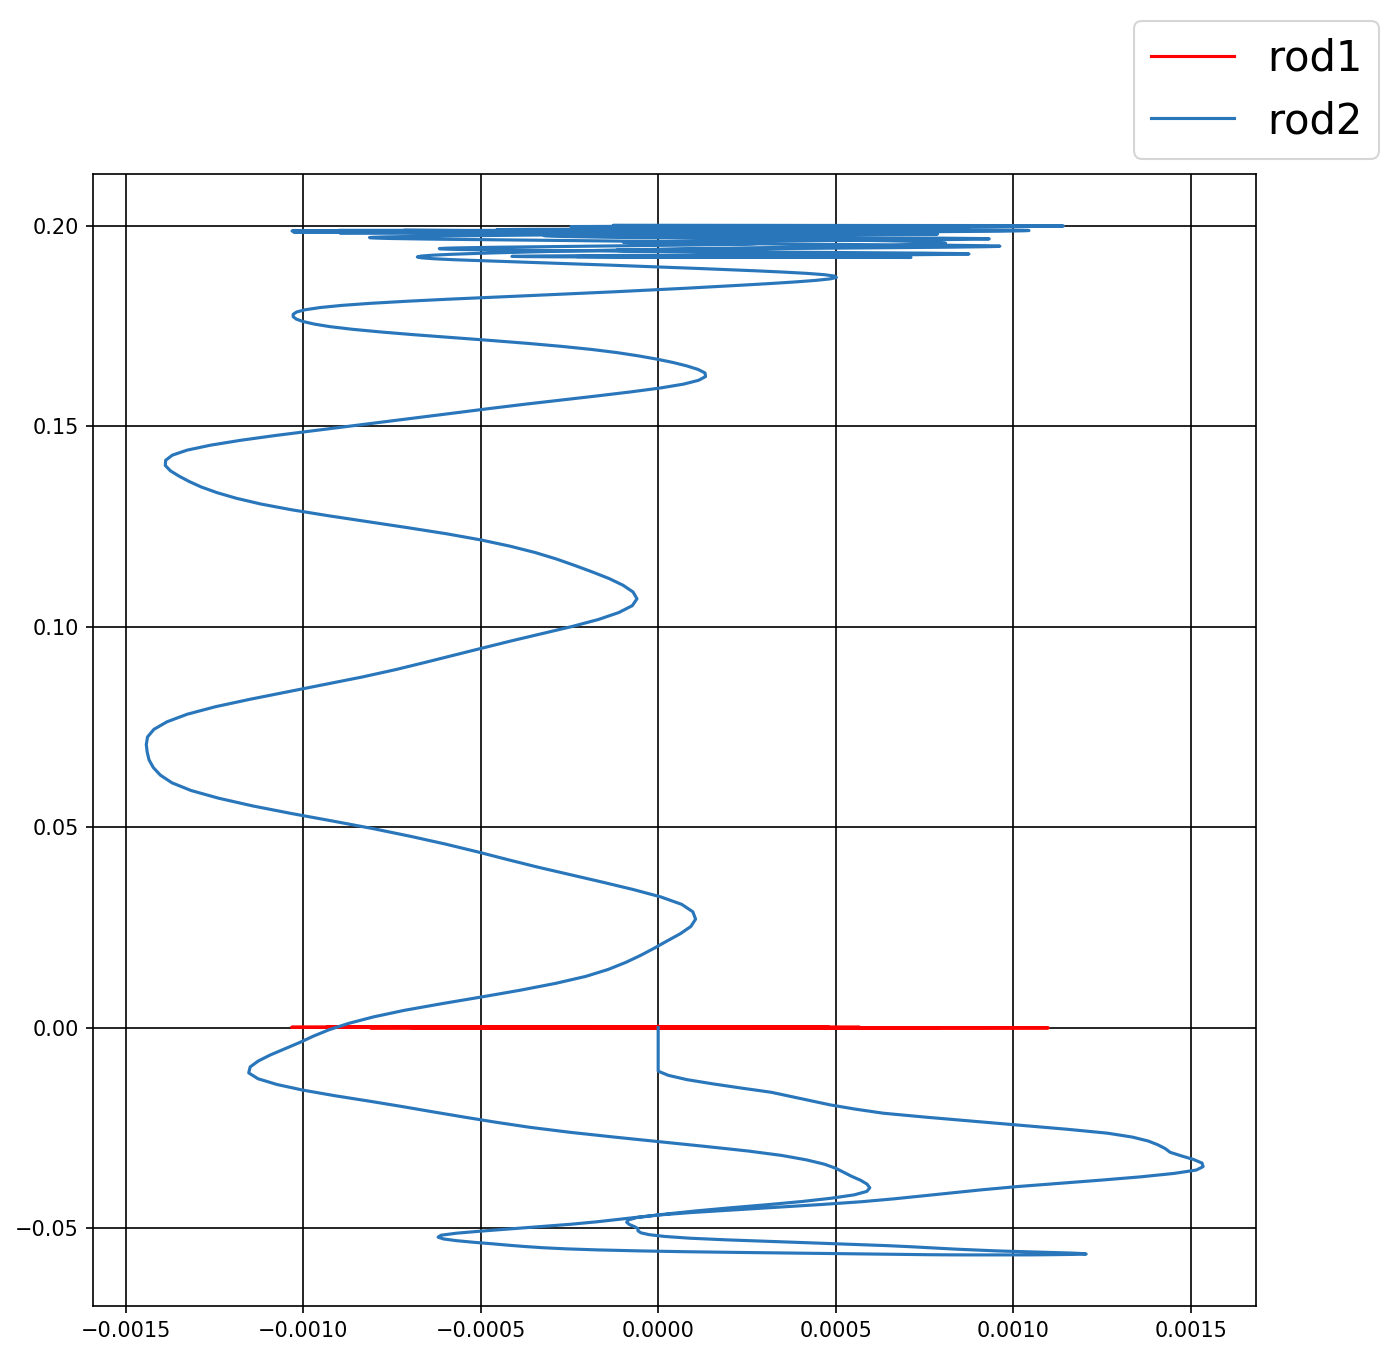

In [15]:
import os
from collections import defaultdict
from elastica.wrappers import (
    BaseSystemCollection,
    Connections,
    Constraints,
    Forcing,
    CallBacks,
)
from elastica.rod.cosserat_rod import CosseratRod
from elastica.boundary_conditions import OneEndFixedRod
from elastica.joint import FreeJoint, HingeJoint
from elastica.callback_functions import CallBackBaseClass
from elastica.timestepper.symplectic_steppers import PositionVerlet, PEFRL
from elastica.timestepper import integrate



class HingeJointSimulator(
    BaseSystemCollection, Constraints, Connections, Forcing, CallBacks
):
    pass


hinge_joint_sim = HingeJointSimulator()

# setting up test params
n_elem = 10
direction = np.array([0.0, 0.0, 1.0])
normal = np.array([0.0, 1.0, 0.0])
roll_direction = np.cross(direction, normal)
base_length = 0.2
base_radius = 0.007
base_area = np.pi * base_radius ** 2
density = 1750
nu = 0.001
E = 3e7
poisson_ratio = 0.5

start_rod_1 = np.zeros((3,))
start_rod_2 = start_rod_1 + direction * base_length

# Create rod 1
rod1 = CosseratRod.straight_rod(
    n_elem,
    start_rod_1,
    direction,
    normal,
    base_length,
    base_radius,
    density,
    nu,
    E,
    poisson_ratio,
)
hinge_joint_sim.append(rod1)
# Create rod 2
rod2 = CosseratRod.straight_rod(
    n_elem,
    start_rod_2,
    direction,
    normal,
    base_length,
    base_radius,
    density,
    nu,
    E,
    poisson_ratio,
)
hinge_joint_sim.append(rod2)

# Apply boundary conditions to rod1.
hinge_joint_sim.constrain(rod1).using(
    OneEndFixedRod, constrained_position_idx=(0,), constrained_director_idx=(0,)
)

# Connect rod 1 and rod 2
hinge_joint_sim.connect(
    first_rod=rod1, second_rod=rod2, first_connect_idx=-1, second_connect_idx=0
).using(
    HingeJoint, k=1e5, nu=0, kt=5e3, normal_direction=roll_direction
)  # 1e-2

# Add forces to rod2
hinge_joint_sim.add_forcing_to(rod2).using(
    EndpointForcesSinusoidal,
    start_force_mag=0,
    end_force_mag=5e-3,
    ramp_up_time=0.2,
    tangent_direction=direction,
    normal_direction=normal,
)

# Callback functions
# Add call backs
class TestJoints(CallBackBaseClass):
    """
    Call back function for testing joints
    """

    def __init__(self, step_skip: int, callback_params: dict):
        CallBackBaseClass.__init__(self)
        self.every = step_skip
        self.callback_params = callback_params

    def make_callback(self, system, time, current_step: int):
        if current_step % self.every == 0:
            self.callback_params["time"].append(time)
            self.callback_params["step"].append(current_step)
            self.callback_params["position"].append(system.position_collection.copy())
            self.callback_params["velocity"].append(system.velocity_collection.copy())
            return


pp_list_rod1 = defaultdict(list)
pp_list_rod2 = defaultdict(list)

# FIXME change callback_of to collect_diagnostics
hinge_joint_sim.collect_diagnostics(rod1).using(
    TestJoints, step_skip=1000, callback_params=pp_list_rod1
)
hinge_joint_sim.collect_diagnostics(rod2).using(
    TestJoints, step_skip=1000, callback_params=pp_list_rod2
)


hinge_joint_sim.finalize()
timestepper = PositionVerlet()
# timestepper = PEFRL()

final_time = 10
dl = base_length / n_elem
dt = 1e-5
total_steps = int(final_time / dt)
print("Total steps", total_steps)
integrate(timestepper, hinge_joint_sim, final_time, total_steps)

PLOT_FIGURE = True
SAVE_FIGURE = False
PLOT_VIDEO = True

# plotting results
if PLOT_FIGURE:
    filename = "hinge_joint_test.png"
    plot_position(pp_list_rod1, pp_list_rod2, filename, SAVE_FIGURE)




plot video
plot video
plot video


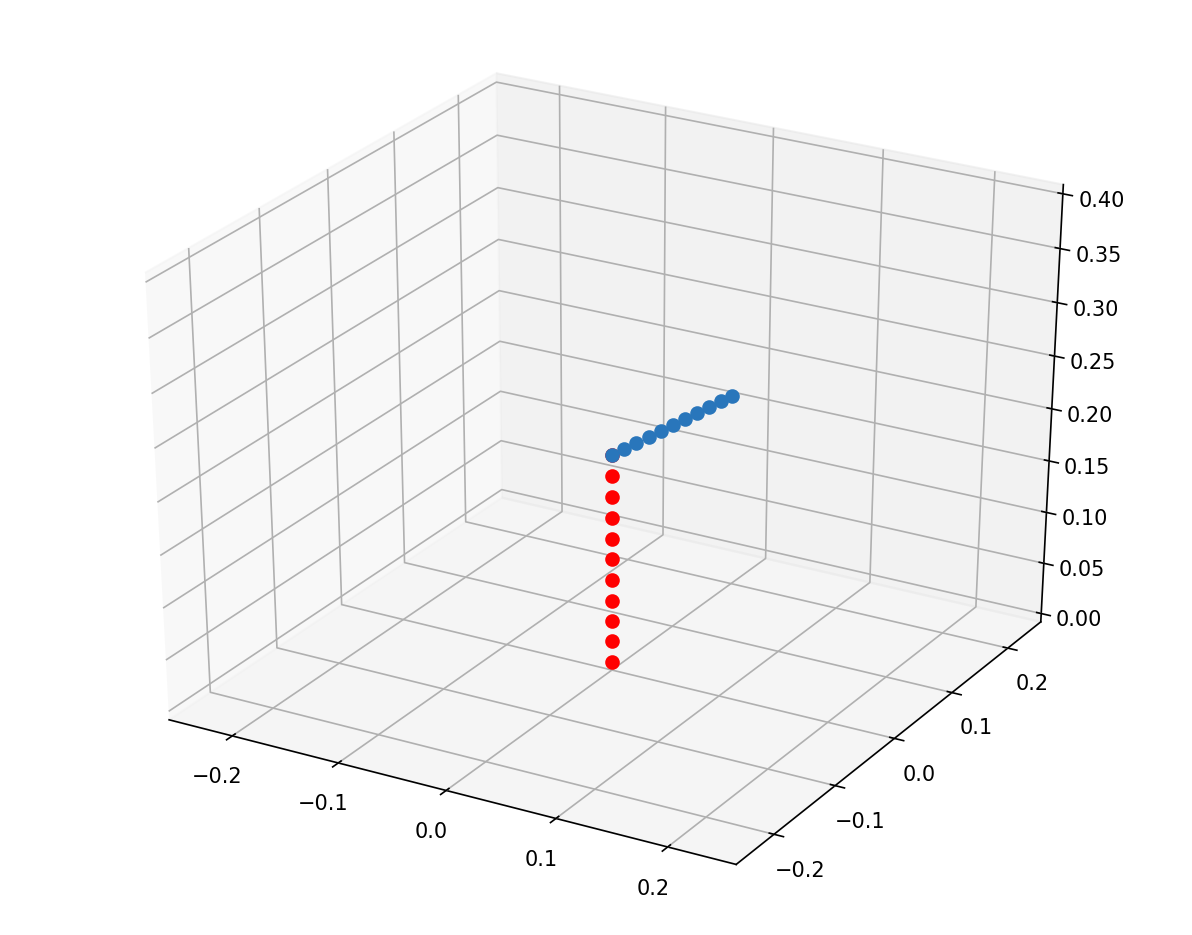

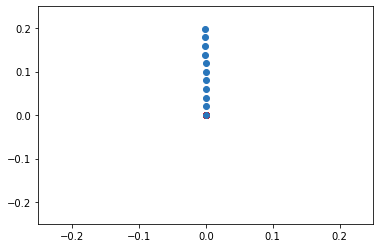

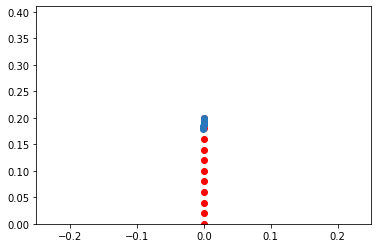

In [16]:

filename = "hinge_joint_test.mp4"
plot_video(pp_list_rod1, pp_list_rod2, video_name=filename, margin=0.2, fps=100)
plot_video_xy(
    pp_list_rod1, pp_list_rod2, video_name=filename + "_xy.mp4", margin=0.2, fps=100
)
plot_video_xz(
    pp_list_rod1, pp_list_rod2, video_name=filename + "_xz.mp4", margin=0.2, fps=100
)


  0%|          | 120/999999 [00:00<13:55, 1197.22it/s]


Total steps 999999


  2%|▏         | 17105/999999 [00:14<13:18, 1230.94it/s]


  3%|▎         | 33530/999999 [00:27<13:35, 1184.46it/s]


  5%|▍         | 49771/999999 [00:41<13:31, 1170.51it/s]


  7%|▋         | 66079/999999 [00:55<13:27, 1156.56it/s]


  8%|▊         | 82420/999999 [01:09<12:56, 1181.02it/s]


 10%|▉         | 98564/999999 [01:23<12:49, 1171.89it/s]


 11%|█▏        | 114572/999999 [01:36<12:21, 1194.50it/s]


 13%|█▎        | 130582/999999 [01:50<12:10, 1190.30it/s]


 15%|█▍        | 146703/999999 [02:04<12:07, 1172.37it/s]


 16%|█▋        | 162887/999999 [02:17<11:40, 1195.84it/s]


 18%|█▊        | 178971/999999 [02:31<11:30, 1189.35it/s]


 20%|█▉        | 195096/999999 [02:45<11:18, 1185.49it/s]


 21%|██        | 211193/999999 [02:58<10:57, 1199.80it/s]


 23%|██▎       | 227304/999999 [03:12<10:54, 1180.59it/s]


 24%|██▍       | 243273/999999 [03:25<10:40, 1182.28it/s]


 26%|██▌       | 259211/999999 [03:39<10:40, 1156.20it/s]


 28%|██▊       | 275226/999999 [03:53<10:16, 1175.94it/s]


 29%|██▉       | 291233/999999 [04:06<09:57, 1186.05it/s]


 31%|███       | 307196/999999 [04:20<09:49, 1175.91it/s]


 32%|███▏      | 323235/999999 [04:34<09:31, 1183.46it/s]


 34%|███▍      | 339287/999999 [04:47<09:26, 1165.61it/s]


 36%|███▌      | 355356/999999 [05:01<08:57, 1199.09it/s]


 37%|███▋      | 371481/999999 [05:15<09:01, 1160.97it/s]


 39%|███▊      | 387459/999999 [05:28<08:54, 1146.69it/s]


 40%|████      | 403614/999999 [05:42<08:25, 1179.50it/s]


 42%|████▏     | 419747/999999 [05:55<08:10, 1184.10it/s]


 44%|████▎     | 435882/999999 [06:09<07:58, 1180.01it/s]


 45%|████▌     | 451963/999999 [06:23<07:58, 1145.39it/s]


 47%|████▋     | 468124/999999 [06:36<07:32, 1174.35it/s]


 48%|████▊     | 484206/999999 [06:50<07:10, 1197.61it/s]


 50%|█████     | 500302/999999 [07:04<07:05, 1173.64it/s]


 52%|█████▏    | 516357/999999 [07:17<06:50, 1178.59it/s]


 53%|█████▎    | 532295/999999 [07:31<06:41, 1163.73it/s]


 55%|█████▍    | 548361/999999 [07:45<06:27, 1165.50it/s]


 56%|█████▋    | 564361/999999 [07:58<06:13, 1167.84it/s]


 58%|█████▊    | 580539/999999 [08:12<05:53, 1185.17it/s]


 60%|█████▉    | 596562/999999 [08:25<05:41, 1182.86it/s]


 61%|██████▏   | 612684/999999 [08:39<05:26, 1188.06it/s]


 63%|██████▎   | 628820/999999 [08:53<05:12, 1187.82it/s]


 64%|██████▍   | 644870/999999 [09:06<05:09, 1148.74it/s]


 66%|██████▌   | 660861/999999 [09:20<04:56, 1143.45it/s]


 68%|██████▊   | 676772/999999 [09:34<04:41, 1147.08it/s]


 69%|██████▉   | 692771/999999 [09:47<04:18, 1189.44it/s]


 71%|███████   | 708833/999999 [10:01<04:04, 1188.75it/s]


 72%|███████▏  | 724896/999999 [10:14<03:59, 1150.45it/s]


 74%|███████▍  | 741000/999999 [10:28<03:35, 1200.11it/s]


 76%|███████▌  | 757096/999999 [10:42<03:26, 1178.50it/s]


 77%|███████▋  | 773277/999999 [10:55<03:09, 1196.20it/s]


 79%|███████▉  | 789330/999999 [11:09<03:06, 1130.42it/s]


 81%|████████  | 805204/999999 [11:23<02:45, 1179.23it/s]


 82%|████████▏ | 821241/999999 [11:36<02:33, 1167.23it/s]


 84%|████████▎ | 837159/999999 [11:50<02:19, 1164.93it/s]


 85%|████████▌ | 853213/999999 [12:04<02:08, 1146.61it/s]


 87%|████████▋ | 869266/999999 [12:17<01:51, 1174.24it/s]


 89%|████████▊ | 885259/999999 [12:31<01:35, 1204.24it/s]


 90%|█████████ | 901312/999999 [12:44<01:22, 1195.24it/s]


 92%|█████████▏| 917443/999999 [12:58<01:08, 1210.23it/s]


 93%|█████████▎| 933589/999999 [13:12<00:55, 1195.65it/s]


 95%|█████████▍| 949505/999999 [13:25<00:42, 1174.52it/s]


 97%|█████████▋| 965543/999999 [13:39<00:29, 1176.31it/s]


 98%|█████████▊| 981595/999999 [13:53<00:15, 1171.02it/s]


100%|█████████▉| 997728/999999 [14:06<00:01, 1176.73it/s]


100%|██████████| 999999/999999 [14:08<00:00, 1178.30it/s]


Final time of simulation is :  10.00000000022981


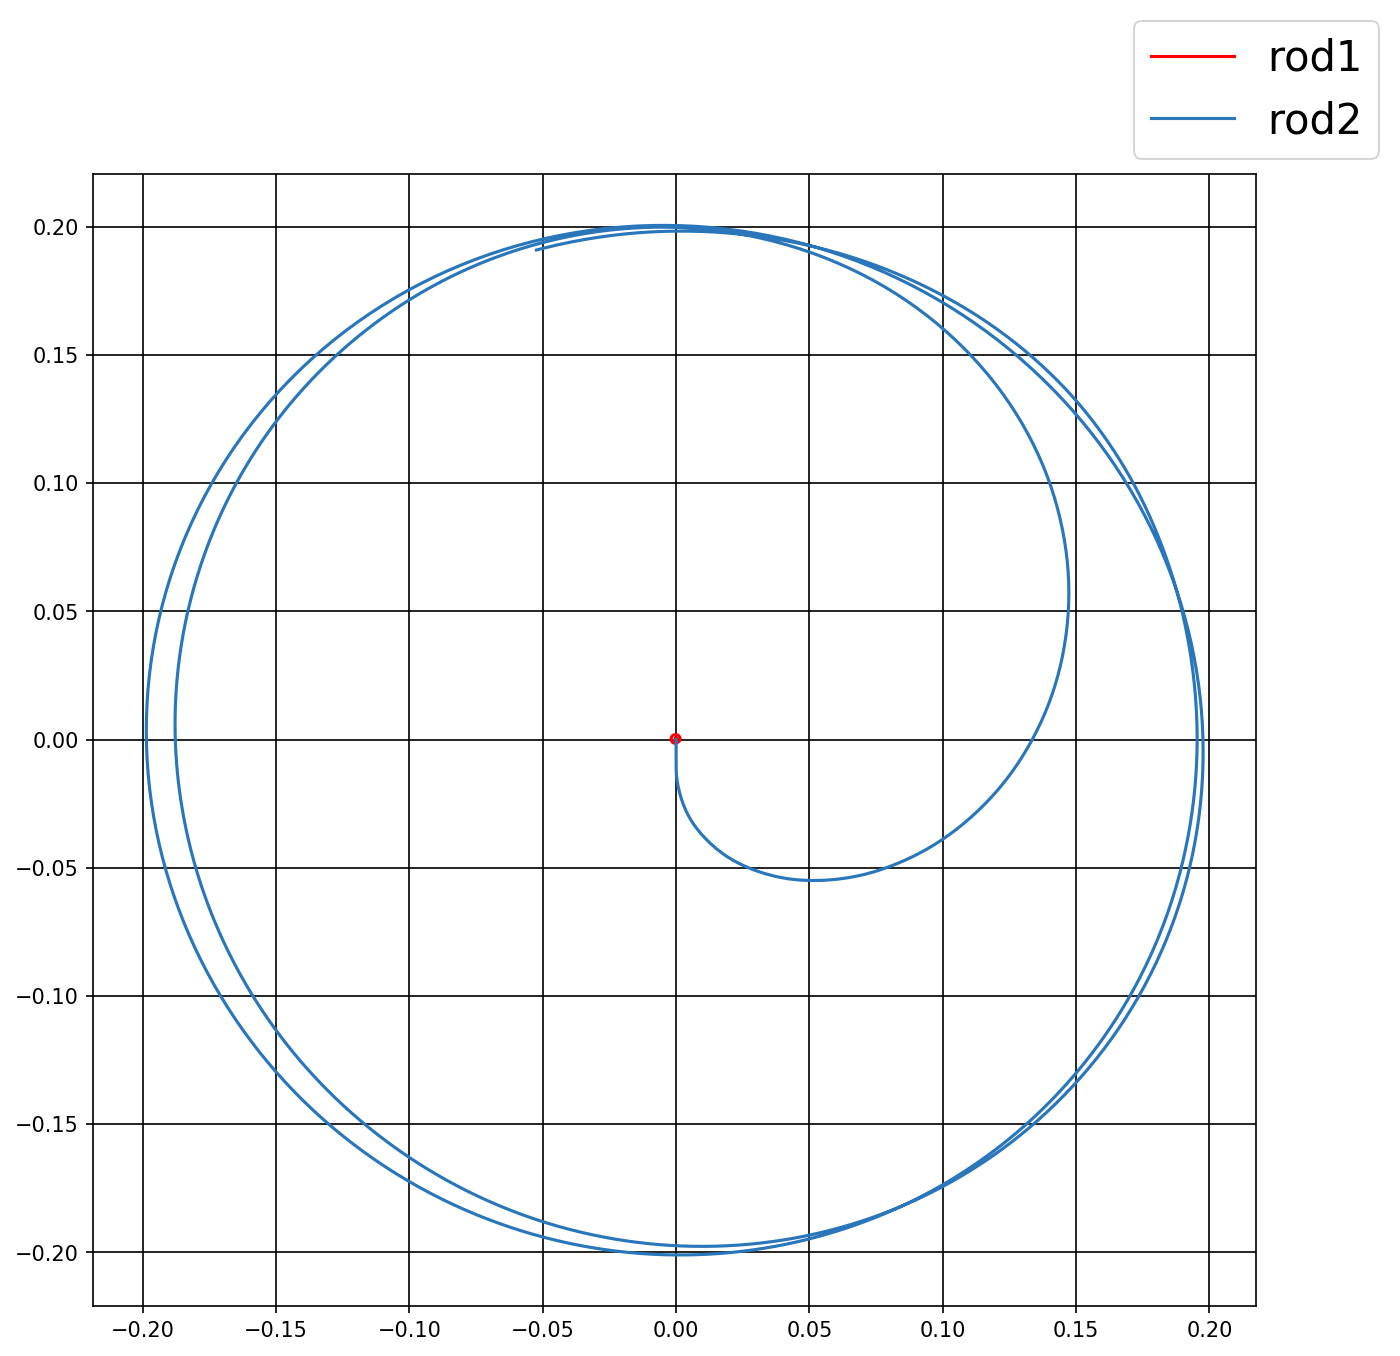

plot video
plot video
plot video


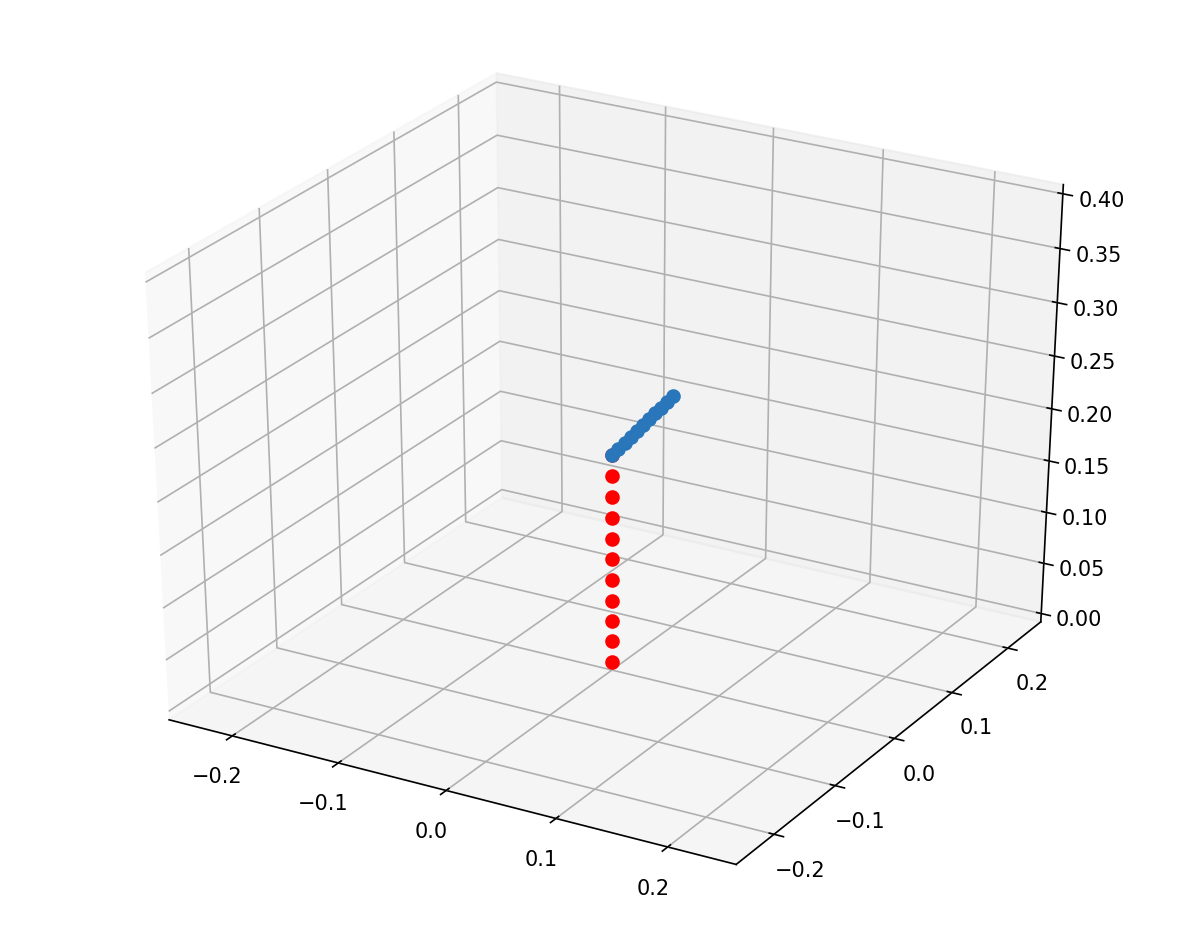

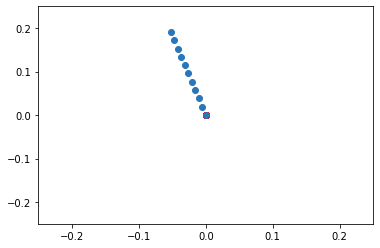

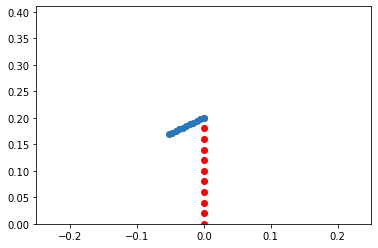

In [17]:
import os
from collections import defaultdict
from elastica.wrappers import (
    BaseSystemCollection,
    Connections,
    Constraints,
    Forcing,
    CallBacks,
)
from elastica.rod.cosserat_rod import CosseratRod
from elastica.boundary_conditions import OneEndFixedRod
from elastica.joint import FreeJoint
from elastica.callback_functions import CallBackBaseClass
from elastica.timestepper.symplectic_steppers import PositionVerlet, PEFRL
from elastica.timestepper import integrate



class SphericalJointSimulator(
    BaseSystemCollection, Constraints, Connections, Forcing, CallBacks
):
    pass


spherical_joint_sim = SphericalJointSimulator()

# setting up test params
n_elem = 10
direction = np.array([0.0, 0.0, 1.0])
normal = np.array([0.0, 1.0, 0.0])
roll_direction = np.cross(direction, normal)
base_length = 0.2
base_radius = 0.007
base_area = np.pi * base_radius ** 2
density = 1750
nu = 1e-3
E = 3e7
poisson_ratio = 0.5

start_rod_1 = np.zeros((3,))
start_rod_2 = start_rod_1 + direction * base_length

# Create rod 1
rod1 = CosseratRod.straight_rod(
    n_elem,
    start_rod_1,
    direction,
    normal,
    base_length,
    base_radius,
    density,
    nu,
    E,
    poisson_ratio,
)
spherical_joint_sim.append(rod1)
# Create rod 2
rod2 = CosseratRod.straight_rod(
    n_elem,
    start_rod_2,
    direction,
    normal,
    base_length,
    base_radius,
    density,
    nu,
    E,
    poisson_ratio,
)
spherical_joint_sim.append(rod2)

# Apply boundary conditions to rod1.
spherical_joint_sim.constrain(rod1).using(
    OneEndFixedRod, constrained_position_idx=(0,), constrained_director_idx=(0,)
)

# Connect rod 1 and rod 2
spherical_joint_sim.connect(
    first_rod=rod1, second_rod=rod2, first_connect_idx=-1, second_connect_idx=0
).using(
    FreeJoint, k=1e5, nu=0
)  # k=kg/s2 nu=kg/s 1e-2

# Add forces to rod2
spherical_joint_sim.add_forcing_to(rod2).using(
    EndpointForcesSinusoidal,
    start_force_mag=0,
    end_force_mag=5e-3,
    ramp_up_time=0.2,
    tangent_direction=direction,
    normal_direction=normal,
)

# Callback functions
# Add call backs
class TestJoints(CallBackBaseClass):
    """
    Call back function for testing joints
    """

    def __init__(self, step_skip: int, callback_params: dict):
        CallBackBaseClass.__init__(self)
        self.every = step_skip
        self.callback_params = callback_params

    def make_callback(self, system, time, current_step: int):
        if current_step % self.every == 0:
            self.callback_params["time"].append(time)
            self.callback_params["step"].append(current_step)
            self.callback_params["position"].append(system.position_collection.copy())
            self.callback_params["velocity"].append(system.velocity_collection.copy())
            return


pp_list_rod1 = defaultdict(list)
pp_list_rod2 = defaultdict(list)

# FIXME change callback_of to collect_diagnostics
spherical_joint_sim.collect_diagnostics(rod1).using(
    TestJoints, step_skip=1000, callback_params=pp_list_rod1
)
spherical_joint_sim.collect_diagnostics(rod2).using(
    TestJoints, step_skip=1000, callback_params=pp_list_rod2
)


spherical_joint_sim.finalize()
timestepper = PositionVerlet()
# timestepper = PEFRL()

final_time = 10
dl = base_length / n_elem
dt = 1e-5
total_steps = int(final_time / dt)
print("Total steps", total_steps)
integrate(timestepper, spherical_joint_sim, final_time, total_steps)

PLOT_FIGURE = True
SAVE_FIGURE = False
PLOT_VIDEO = True

# plotting results
if PLOT_FIGURE:
    filename = "spherical_joint_test_last_node_pos_xy.png"
    plot_position(pp_list_rod1, pp_list_rod2, filename, SAVE_FIGURE)




plot video
plot video
plot video


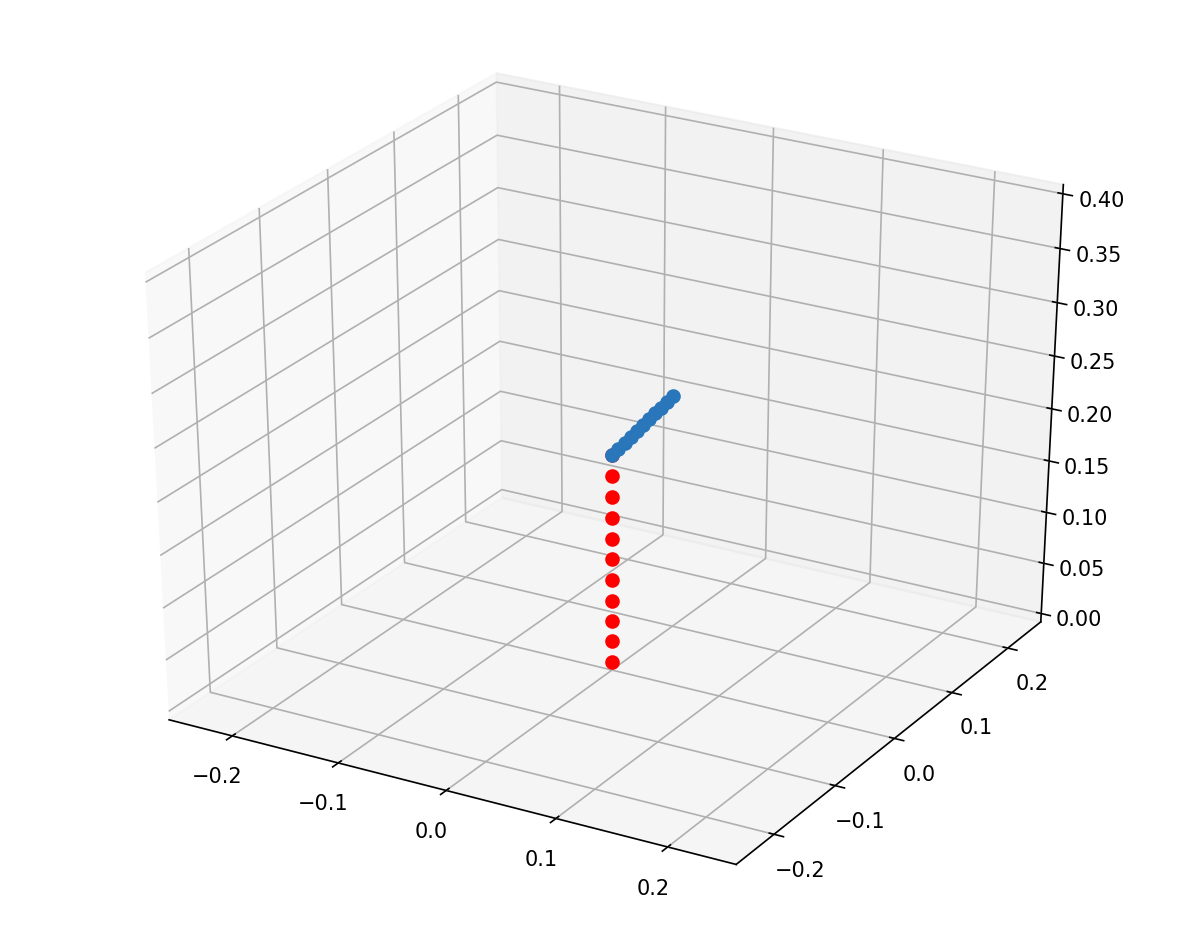

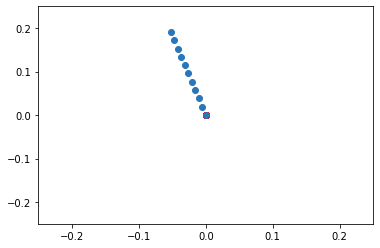

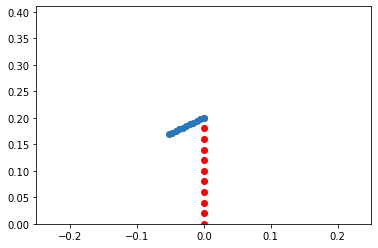

In [18]:
filename = "spherical_joint_test.mp4"
plot_video(pp_list_rod1, pp_list_rod2, video_name=filename, margin=0.2, fps=100)
plot_video_xy(
    pp_list_rod1, pp_list_rod2, video_name=filename + "_xy.mp4", margin=0.2, fps=100
)
plot_video_xz(
    pp_list_rod1, pp_list_rod2, video_name=filename + "_xz.mp4", margin=0.2, fps=100
)